Before we begin with the LASSO deblurring, we must first set up the workspace by importing the modules and matrices we'll be using in the activity.

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

X_true = np.array(loadmat('Clear.mat')['C'])
B_orig = np.array(loadmat('Blurry.mat')['B'])
PSF = np.array(loadmat('PSF.mat')['PSF'])
psf = np.array(loadmat('alt_PSF.mat')['psf'])

This blurry image was produced only by applying the PSF (Point Spread Function) to the clear image in X_true. In reality, there will also be some independent noise which is added to the blurry image so that is what we do below after showing you what the image looks like with only the blurring function.

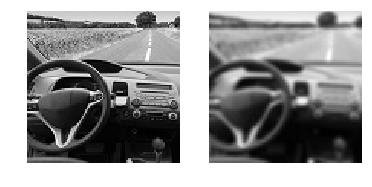

In [3]:
# Before adding the independent noise, let's first take a look at what the blurry and clear images look
# like without noise
fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(X_true, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(122)
ax.imshow(B_orig, cmap='gray')
ax.set_axis_off()

In [4]:
# Here we define the noise function which will add light/dark specs to the image randomly.
def noise(image,probability,rgb):
    output = np.zeros(image.shape)
    thres = 1 - probability
    if(rgb == True):
        for i in range(image.shape[0]): # Each Pixel X
            for j in range(image.shape[1]): # Each Pixel Y
                for k in range(image.shape[2]): #Each of the 3 color values (R,G,B)
                    rdn = random.random() 
                    if rdn < probability:
                        output[i][j][k] = 0.0 # Empty, no color on that value, if rgb for this pixel is 0,0,0 color is White
                    elif rdn > thres:
                        output[i][j][k] = 1.0 # Highest value a color value can take, if rgb for this pixel are all 1, color is Black
                    else:
                        output[i][j][k] = image[i][j][k] # copy original's pixel r,g,b if probability not met
    else:
        for i in range(image.shape[0]): # Each Pixel X
            for j in range(image.shape[1]): # Each Pixel Y
                rdn = random.random() 
                if rdn < probability:
                    output[i][j] = 0.0 # Empty, no color on that value, if rgb for this pixel is 0,0,0 color is White
                elif rdn > thres:
                    output[i][j] = 1.0 # Highest value a color value can take, if rgb for this pixel are all 1, color is Black
                else:
                    output[i][j] = image[i][j] # copy original's pixel if probability not met
    return output

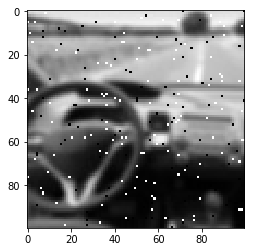

In [5]:
# Now that we've defined the function to add the independent noise, we add some to our blurry image and display it
B = noise(B_orig,0.01, False)
plt.imshow(B, cmap='gray')

In theory, it is absolutely possible to get the clear image from the original blurry one just using the PSF like we show below. However, the addition of the independant noise greatly corrupts this result. **See for yourself by completing the code below to try this method with the blurry image with noise added.**

When no independent noise is present, the clear image can be extracted easily using only the PSF


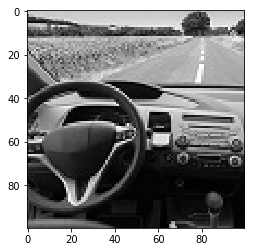

In [6]:
# To get the clear image just using the original B (without independent noise), we simply solve the equation B_orig = PSF@X
# This results in X = PSF_inverse@B_orig
PSF_inverse = np.linalg.inv(PSF)
X = PSF_inverse@B_orig
plt.imshow(X, cmap='gray')
print('When no independent noise is present, the clear image can be extracted easily using only the PSF')

Once independent noise is introduced, the result of this method becomes much worse


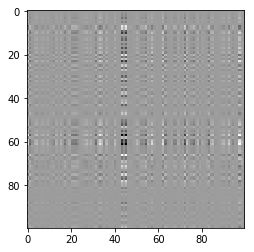

In [12]:
# Now let's try the same procedure using the blurry image WITH independent noise
X = PSF_inverse@B
plt.imshow(X, cmap='gray')

To address the inaccuracy introduced by the independent noise, we use L1-norm regularization (LASSO). Since LASSO doesn't allow for a closed for solution (it isn't differentiable), we must use gradient descent to find the optimum solution. We have provided you with a function which can do this **once the section computing z^(k+1) is filled in**. The main modification we need to do first, is to reshape our image to an N^2x1 vector (instead of the NxN matrix it currently is) which can then be passed into the function. We can't use the same PSF from before since that PSF was made to work on the matrix form but we have already generated a version that will work with the vector form and is saved in psf.

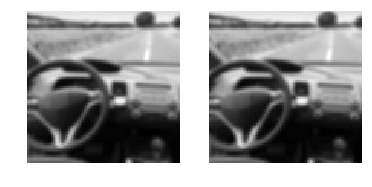

In [8]:
# Converting the matrix to a vector
b = np.reshape(B, (B.shape[0]*B.shape[1],1))

# Proving the psf works with the vector format of the images
x = np.reshape(X_true, b.shape)
B1 = np.reshape(psf@x, X_true.shape).T

fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(B_orig, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(122)
ax.imshow(B1, cmap='gray')
ax.set_axis_off()

The images above are both blurred images but the one on the left is the original blurred image that we loaded at the beginning of the activity. The one on the right was generated from the vector form of X_true, the clear image, using the version of the psf which is made for use with the vector form of the images.

In [9]:
def prxgraddescent_l1(X,y,tau,lam,w_init,it):

## compute it iterations of L2 proximal gradient descent starting at w1
## w_{k+1}= (w_k - tau*X'*(X*w_k - y)/(1+lam*tau)
## step size tau
    W = np.zeros((w_init.shape[0], it+1))
    Z = np.zeros((w_init.shape[0], it+1))
    W[:,[0]] = w_init
    for k in range(it):
        
        # Complete the next line of code using information from the activity document
        Z[:,[k+1]] = W[:,[k]] - tau * X.T @ (X @ W[:,[k]] - y);
        
        W[:,[k+1]] = np.sign(Z[:,[k+1]])* np.clip(np.abs(Z[:,[k+1]])-lam*tau/2,0,float("inf"))
        
    return W,Z

Now we can easily compute the image deblurred using LASSO by simply passing the blurry image and the PSF into the proximal gradient descent function above. **Try out some different values for lambda and tau to see what effect they have on the resulting image.**

In [10]:
tau = 0.25
lam = 4
max_iter = 20

W,Z = prxgraddescent_l1(psf.T,np.ones((len(b),1)),tau,lam,b,max_iter)

Now let's plot the image that results from the final iteration of the above code block

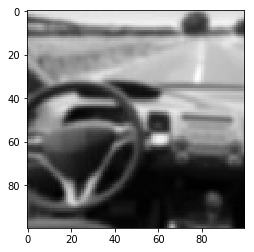

In [11]:
X = np.reshape(W[:,-1], (B.shape[0], B.shape[1])).T
plt.imshow(X, cmap='gray')

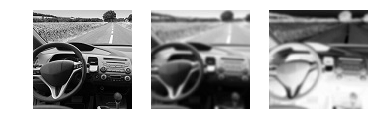

In [12]:
E = X_true - X

fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(X_true, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(132)
ax.imshow(X, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(133)
ax.imshow(E, cmap='gray')
ax.set_axis_off()
plt.show()

The images above are, from left to right, the original clear image, the result of our gradient descent with LASSO regularization, and the difference between the first two. **Comment on the effectiveness of the image deblurring process and the effect of lambda and tau.**